In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import os
rc('font',**{'family':'sans-serif','sans-serif':'Arial'})
rc('text',usetex=True)
letters = ['A','T','C','G']
filelabels = ['CDS','UTR']

In [ ]:
files = os.listdir('./ProteinCodingOrthologs/downloaded')
path = './ProteinCodingOrthologs/downloaded'
Archetypes = ['GCF_015852505.1_mTacAcu1.pri', 'GCF_016433145.1_AgileGrace', 'GCA_016432865.2_AdamAnt_v2',
         'GCF_000313985.2_ASM31398v2', 'GCA_000152225.2_Pcap_2.0', 'GCF_014898055.1_MPIMG_talOcc4',
         'GCF_000296755.1_EriEur2.0', 'GCA_029834395.2_SorCin_2.1', 'Human_NEAT1', 'GCA_013371645.1_OryCun3.0',
         'GCF_014633375.1_OchPri4.0', 'GCF_020740685.1_mJacJac1.mat.Y.cur', 'GCA_023101885.1_KIZ_TCIN_v1.0',
         'Mouse_NEAT1','GCF_019054845.1_ASM1905484v1', 'GCA_004027875.1_AplRuf_v1_BIUU']

In [ ]:
latin = {}
genera = {}
species = {}
arch = {}
with open('Metadata') as file1:
    for line in file1:
        dat = line.strip().split('\t')
        if not line.startswith('#'):
            if dat[3] == '1' or dat[4] == '1':
                latin[dat[0]] = dat[20]
                species[dat[20]] = ''
                genus = dat[20].split(' ')[0]
                if genus not in genera:
                    genera[genus] = set()
                genera[genus].add(dat[20].split(' ')[1])
                if dat[0] in Archetypes:
                    arch[dat[20]] = dat[0]

In [ ]:
filenames = ['cds','3p_utr']
filelabels = ['CDS','UTR']
#Going through downloaded fasta files with protein-coding genes orthologs one by one
for gene in files:
    #Files are separate for CDS and 3p-UTR
    for j in range(2):
        filename = filenames[j]
        filelabel = filelabels[j]
        #temporary dict for found species and genera in orthologs fasta
        a = {}
        ag = {}
        with open(path + '/' + gene + '/' + filename + '.fna') as file1:
            for line in file1:
                if line.startswith('>'):
                    dat = line.strip().split('[')
                    flag = 0
                    for item in dat:
                        if 'transcript' in item:
                            if 'X1' not in item:
                                flag = 1
                    if flag == 0:
                        for item in dat:
                            if 'organism' in item:
                                name = ' '.join(item.replace(']','').split('=')[1].split(' ')[:2])
                                name_genus = name.split(' ')[0]
                                a[name] = line
                                if name_genus not in ag:
                                    ag[name_genus] = line
        #Select only species and genera which are part of our dataset with NEAT1 orthologs
        #Separately for all NEAT1 orthologs and archetypes
        sel = {}
        selarch = {}
        for item in arch:
            if item in a:
                selarch[a[item]] = ''
            else:
                if item.split(' ')[0] in ag:
                    selarch[ag[item.split(' ')[0]]] = ''
        for item in species:
            if item in a:
                sel[a[item]] = ''
            else:
                if item.split(' ')[0] in ag:
                    sel[ag[item.split(' ')[0]]] = ''
        
        #Leave only genes with more than 150 genera and sequences of genera relevant for our study only 
        if len(sel) >= 150:
            out = open('./Orthologs/all/' + filelabel + '/' + gene + '_' + filelabel + '.fasta','w')                        
            flag = 0
            with open(path + '/' + gene + '/' + filename + '.fna') as file1:
                for line in file1:
                    if line.startswith('>') and line in sel:
                        dat = line.strip().split('[')
                        for item in dat:
                            if 'organism' in item:
                                name = ' '.join(item.replace(']','').split('=')[1].split(' ')[:2])
                        out.write(line.split(' ')[0] + ' ' + gene + ':' + name + '\n')
                        flag = 1
                    elif line.startswith('>') and line not in sel:
                        flag = 0
                    elif not line.startswith('>') and flag == 1:
                        out.write(line)  
            out.close()
        #For archtypes we applied threshold of at least 10 orthologs
        if len(selarch) >= 10:
            out = open('./Orthologs/archetypes/' + filelabel + '/' + gene + '_' + filelabel + '.fasta','w')                        
            flag = 0
            with open(path + '/' + gene + '/' + filename + '.fna') as file1:
                for line in file1:
                    if line.startswith('>') and line in selarch:
                        dat = line.strip().split('[')
                        for item in dat:
                            if 'organism' in item:
                                name = ' '.join(item.replace(']','').split('=')[1].split(' ')[:2])
                        out.write(line.split(' ')[0] + ' ' + gene + ':' + name + '\n')
                        flag = 1
                    elif line.startswith('>') and line not in selarch:
                        flag = 0
                    elif not line.startswith('>') and flag == 1:
                        out.write(line)  
            out.close()

In [ ]:
#Analyse the nucleotide usage in orthologs of selected genes
filelabels = ['CDS','UTR']
d = {}

for filelabel in filelabels:
    d[filelabel] = {}
    for gene in files:
        try:
            d[filelabel][gene] = {}
            with open('./Orthologs/all/' + filelabel + '/' + gene + '_' + filelabel + '.fasta') as file1:
                fl = 0
                for line in file1:
                    if line.startswith('>') and fl == 0:
                        l = []
                        name = line.rstrip().split(':')[-1]
                        fl = 1
                    elif line.startswith('>') and fl == 1:
                        d[filelabel][gene][name] = {}
                        seq = ''.join(l)
                        length = len(seq)
                        for letter in ['A','T','C','G']:
                            d[filelabel][gene][name][letter] = round((seq.count(letter)/length)*100,2)
                        l = []
                        name = line.rstrip().split(':')[-1]
                    elif not line.startswith('>'):
                        l.append(line.strip())
            d[filelabel][gene][name] = {}
            seq = ''.join(l)
            length = len(seq)
            for letter in letters:
                d[filelabel][gene][name][letter] = round((seq.count(letter)/length)*100,2)
        except:
            pass
json.dump(d, open('./Orthologs/NucleotideUsage_CDS_UTR.json',"w"))

### Make a plot from Fig.5E

In [3]:
d = json.load(open('./Orthologs/NucleotideUsage_CDS_UTR.json',"r"))
print(d.keys())

dict_keys(['CDS', 'UTR'])


In [12]:
print(list(d['CDS'].keys())[:10])
print(d['CDS']['A3GALT2']['Ursus americanus'])

['A3GALT2', 'ABCC6', 'ABHD14A', 'ABRAXAS1', 'ACAD10', 'ACADS', 'ACO2', 'ACOT11', 'ACTC1', 'ACVR2B']
{'A': 13.49, 'T': 17.01, 'C': 33.92, 'G': 35.58}


In [6]:
#Make a list with species, one per family
families2 = []
with open('./PhyloTree/leaves_order_one_per_family') as file1:
    for line in file1:
        dat = line.strip().split('\t')
        families2.append(dat[1])
#Parse genes FASTA files
seq = {}
seq_file = './NEAT1_gene_all.fasta'
with open(seq_file) as file1:
    fl = 0
    for line in file1:
        if line.startswith('>') and fl == 0:
            l = []
            name = line.rstrip().lstrip('>')
            fl = 1
        elif line.startswith('>') and fl == 1:
            seq[name] = ''.join(l)
            l = []
            name = line.rstrip().lstrip('>')
        elif not line.startswith('>'):
            l.append(line.strip())
    seq[name] = ''.join(l)

seq2 = {}
seq_file = './MALAT1_gene_all.fasta'
with open(seq_file) as file1:
    fl = 0
    for line in file1:
        if line.startswith('>') and fl == 0:
            l = []
            name = line.rstrip().lstrip('>')
            fl = 1
        elif line.startswith('>') and fl == 1:
            seq2[name] = ''.join(l)
            l = []
            name = line.rstrip().lstrip('>')
        elif not line.startswith('>'):
            l.append(line.strip())
    seq2[name] = ''.join(l)

In [10]:
#Reformat dictionary d into more convenient for plotting form
genelist = list(set(list(d['CDS'].keys()) + list(d['UTR'].keys())))
val = {}
for filelabel in filelabels:
    val[filelabel] = {}
    for gene in genelist:
        if gene in d[filelabel]:
            val[filelabel][gene] = {i:[] for i in letters}
            for name in d[filelabel][gene]:
                for letter in letters:
                    val[filelabel][gene][letter].append(d[filelabel][gene][name][letter])


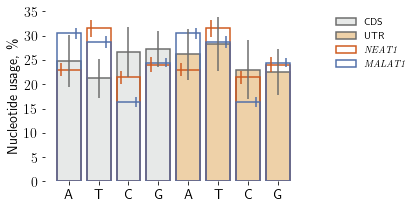

In [35]:
nucneat = {i:[] for i in letters}
families = [i for i in families2 if i in seq]
#Calculate mean nucleotide usage for NEAT1 orthologs
for gene in families:
    allen = len(seq[gene])
    for letter in letters:
        nucneat[letter].append(seq[gene].count(letter)/allen*100)
nval = [np.mean(nucneat[letter]) for letter in letters]
nerr = [np.std(nucneat[letter]) for letter in letters]

#Calculate mean nucleotide usage for MALAT1 orthologs
nucmal = {i:[] for i in letters}
families = [i for i in families2 if i in seq2]
for gene in families:
    allen = len(seq2[gene])
    for letter in letters:
        nucmal[letter].append(seq2[gene].count(letter)/allen*100)
mval = [np.mean(nucmal[letter]) for letter in letters]
merr = [np.std(nucmal[letter]) for letter in letters]

#Calculate mean nucleotide usage for CDSs of protein-coding genes
filelabel = 'CDS'
a = []
err = []
for letter in letters:
    inter = [float(np.mean(val[filelabel][gene][letter])) for gene in val[filelabel]]
    a.append(np.nanmean(inter))
    err.append(np.nanstd(inter))
    
#plot first four columns
pos = [i for i in range(len(a))]

plt.figure(figsize=(6,3))
plt.bar(pos,a,yerr=err, color='#e7e9e8',edgecolor='#6c6c6c',
        error_kw={'linewidth':0.5,'linewidth':1.5,'ecolor':'#6c6c6c'},linewidth=1.5,label='CDS')

plt.bar(pos,nval, color='None', fill=False, edgecolor='#ce591e',linewidth=1.5)
plt.errorbar([i - 1/4 for i in pos], nval, yerr=nerr, linestyle='none', color='#ce591e')

plt.bar(pos,mval, color='None', fill=False, edgecolor='#516fa9',linewidth=1.5)
plt.errorbar([i + 1/4 for i in pos], mval, yerr=merr, linestyle='none', color='#516fa9')

#Calculate mean nucleotide usage for UTRs of protein-coding genes
filelabel = 'UTR'
a = []
err = []
for letter in letters:
    inter = [float(np.mean(val[filelabel][gene][letter])) for gene in val[filelabel]]
    a.append(np.nanmean(inter))
    err.append(np.nanstd(inter))
pos = range(4,8)

#Finish the plot
plt.bar(pos,a,yerr=err, color='#eed1a8',edgecolor='#6c6c6c',
        error_kw={'linewidth':0.5,'linewidth':1.5,'ecolor':'#6c6c6c'},linewidth=1.5,label='UTR')

plt.bar(pos,nval, color='None', fill=False, edgecolor='#ce591e',linewidth=1.5,label=r"$\mathit{NEAT1}$")
plt.errorbar([i - 1/4 for i in pos], nval, yerr=nerr, linestyle='none', color='#ce591e')

plt.bar(pos,mval, color='None', fill=False, edgecolor='#516fa9',linewidth=1.5, label=r"$\mathit{MALAT1}$")
plt.errorbar([i + 1/4 for i in pos], mval, yerr=merr, linestyle='none', color='#516fa9')


plt.ylabel('Nucleotide usage, \%',fontsize=14)
plt.box(False)

plt.legend(bbox_to_anchor=(1.1, 1),fontsize=10,frameon=False)
plt.xticks(range(8),letters+letters,fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('./FiguresPublication/NuclUsageOrthologNEAT1MALAT1.pdf',dpi=300)